# Enhanced Digit Recognition Training
This notebook trains an improved neural network for digit recognition with comprehensive evaluation and model saving.

## 1. Import Required Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
from datetime import datetime

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Ignore TensorFlow info messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

## 2. GPU Configuration

In [2]:
# Configure GPU if available
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print(f"Number of GPUs available: {len(gpu_devices)}")
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU available, using CPU")

Number of GPUs available: 1


## 3. Load and Prepare Dataset

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Training set shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set shape: (60000, 28, 28)
Training labels shape: (60000,)
Test set shape: (10000, 28, 28)
Test labels shape: (10000,)


## 4. Visualize Sample Data

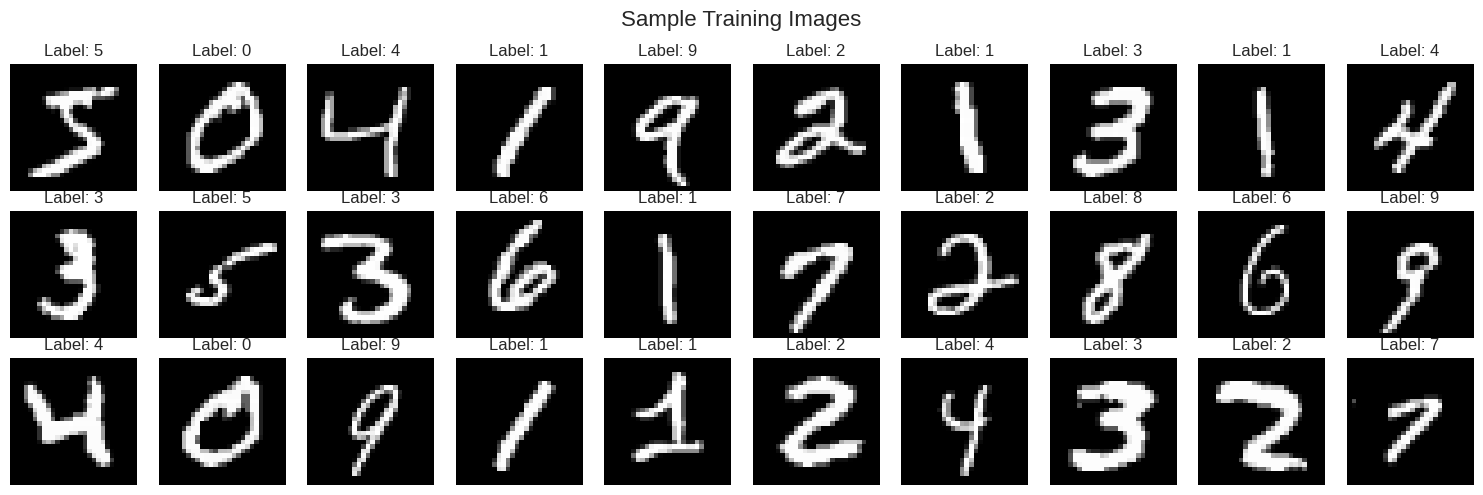

In [5]:
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Display sample images
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
fig.suptitle('Sample Training Images', fontsize=16)

for i in range(30):
    row = i // 10
    col = i % 10
    axes[row, col].imshow(x_train[i], cmap='gray')
    axes[row, col].set_title(f'Label: {y_train[i]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "sample_images.png"),
            dpi=150, bbox_inches='tight')
plt.show()


## 5. Data Preprocessing

In [6]:
# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for neural network (flatten to 784 features)
x_train_flat = x_train.reshape(-1, 28*28)
x_test_flat = x_test.reshape(-1, 28*28)

print(f"Preprocessed training shape: {x_train_flat.shape}")
print(f"Preprocessed test shape: {x_test_flat.shape}")

Preprocessed training shape: (60000, 784)
Preprocessed test shape: (10000, 784)


## 6. Build Improved Model Architecture

In [7]:
# Create improved model with dropout and batch normalization
model = keras.Sequential([
    keras.Input(shape=(28*28,)),

    # First hidden layer
    layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Second hidden layer
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Third hidden layer
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Output layer
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571,018 (2.18 MB)

 Trainable params: 569,226 (2.17 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 7. Compile Model

In [8]:
# Compile with Adam optimizer and learning rate scheduling
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 8. Setup Training Callbacks

In [9]:
# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

# Define callbacks
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        'output/best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

## 9. Train the Model

In [10]:
# Train the model
history = model.fit(
    x_train_flat, y_train,
    batch_size=128,
    epochs=30,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
367/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8143 - loss: 0.6039
Epoch 1: val_accuracy improved from -inf to 0.96133, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8163 - loss: 0.5978 - val_accuracy: 0.9613 - val_loss: 0.1278 - learning_rate: 0.0010
Epoch 2/30
365/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9481 - loss: 0.1668
Epoch 2: val_accuracy improved from 0.96133 to 0.96850, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9482 - loss: 0.1665 - val_accuracy: 0.9685 - val_loss: 0.0982 - learning_rate: 0.0010
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9614 - loss: 0.1233
Epoch 3: val_accuracy improved from 0.96850 to 0.97008, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9614 - loss: 0.1233 - val_accuracy: 0.9701 - val_loss: 0.0987 - learning_rate: 0.0010
Epoch 4/30
364/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9691 - loss: 0.1004
Epoch 4: val_accuracy improved from 0.97008 to 0.97417, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9691 - loss: 0.1003 - val_accuracy: 0.9742 - val_loss: 0.0869 - learning_rate: 0.0010
Epoch 5/30
372/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9734 - loss: 0.0831
Epoch 5: val_accuracy did not improve from 0.97417
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9734 - loss: 0.0831 - val_accuracy: 0.9737 - val_loss: 0.0867 - learning_rate: 0.0010
Epoch 6/30
372/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9760 - loss: 0.0729
Epoch 6: val_accuracy improved from 0.97417 to 0.97808, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9760 - loss: 0.0729 - val_accuracy: 0.9781 - val_loss: 0.0804 - learning_rate: 0.0010
Epoch 7/30
368/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9810 - loss: 0.0587
Epoch 7: val_accuracy did not improve from 0.97808
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9810 - loss: 0.0587 - val_accuracy: 0.9755 - val_loss: 0.0863 - learning_rate: 0.0010
Epoch 8/30
368/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9823 - loss: 0.0529
Epoch 8: val_accuracy improved from 0.97808 to 0.97858, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9823 - loss: 0.0529 - val_accuracy: 0.9786 - val_loss: 0.0756 - learning_rate: 0.0010
Epoch 9/30
364/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9825 - loss: 0.0520
Epoch 9: val_accuracy did not improve from 0.97858
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9825 - loss: 0.0519 - val_accuracy: 0.9772 - val_loss: 0.0847 - learning_rate: 0.0010
Epoch 10/30
366/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9835 - loss: 0.0483
Epoch 10: val_accuracy improved from 0.97858 to 0.97875, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9835 - loss: 0.0483 - val_accuracy: 0.9787 - val_loss: 0.0800 - learning_rate: 0.0010
Epoch 11/30
371/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9853 - loss: 0.0423
Epoch 11: val_accuracy improved from 0.97875 to 0.97925, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9853 - loss: 0.0423 - val_accuracy: 0.9793 - val_loss: 0.0746 - learning_rate: 0.0010
Epoch 12/30
367/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - loss: 0.0368
Epoch 12: val_accuracy improved from 0.97925 to 0.97983, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9876 - loss: 0.0368 - val_accuracy: 0.9798 - val_loss: 0.0774 - learning_rate: 0.0010
Epoch 13/30
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9879 - loss: 0.0366
Epoch 13: val_accuracy improved from 0.97983 to 0.98033, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9879 - loss: 0.0366 - val_accuracy: 0.9803 - val_loss: 0.0771 - learning_rate: 0.0010
Epoch 14/30
363/375 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9883 - loss: 0.0351
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: val_accuracy did not improve from 0.98033
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9883 - loss: 0.0350 - val_accuracy: 0.9783 - val_loss: 0.0843 - learning_rate: 0.0010
Epoch 15/30
370/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9902 - loss: 0.0274
Epoch 15: val_accuracy improved from 0.98033 to 0.98283, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9902 - loss: 0.0273 - val_accuracy: 0.9828 - val_loss: 0.0683 - learning_rate: 5.0000e-04
Epoch 16/30
366/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0190
Epoch 16: val_accuracy did not improve from 0.98283
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9935 - loss: 0.0190 - val_accuracy: 0.9827 - val_loss: 0.0664 - learning_rate: 5.0000e-04
Epoch 17/30
367/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9948 - loss: 0.0152
Epoch 17: val_accuracy improved from 0.98283 to 0.98383, saving model to output/best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9948 - loss: 0.0153 - val_accuracy: 0.9838 - val_loss: 0.0699 - learning_rate: 5.0000e-04
Epoch 18/30
366/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0154
Epoch 18: val_accuracy did not improve from 0.98383
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9946 - loss: 0.0154 - val_accuracy: 0.9829 - val_loss: 0.0756 - learning_rate: 5.0000e-04
Epoch 19/30
363/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9952 - loss: 0.0135
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: val_accuracy did not improve from 0.98383
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9952 - loss: 0.0135 - val_accuracy: 0.9831 - val_loss: 0.0719 - learning_rate: 5.0000e-04
Epoch 20/30
363/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9956 - loss: 0.0130
Epoch 20: val_accuracy did not improve from 0.98383
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9956 - loss: 0.

## 10. Plot Training History

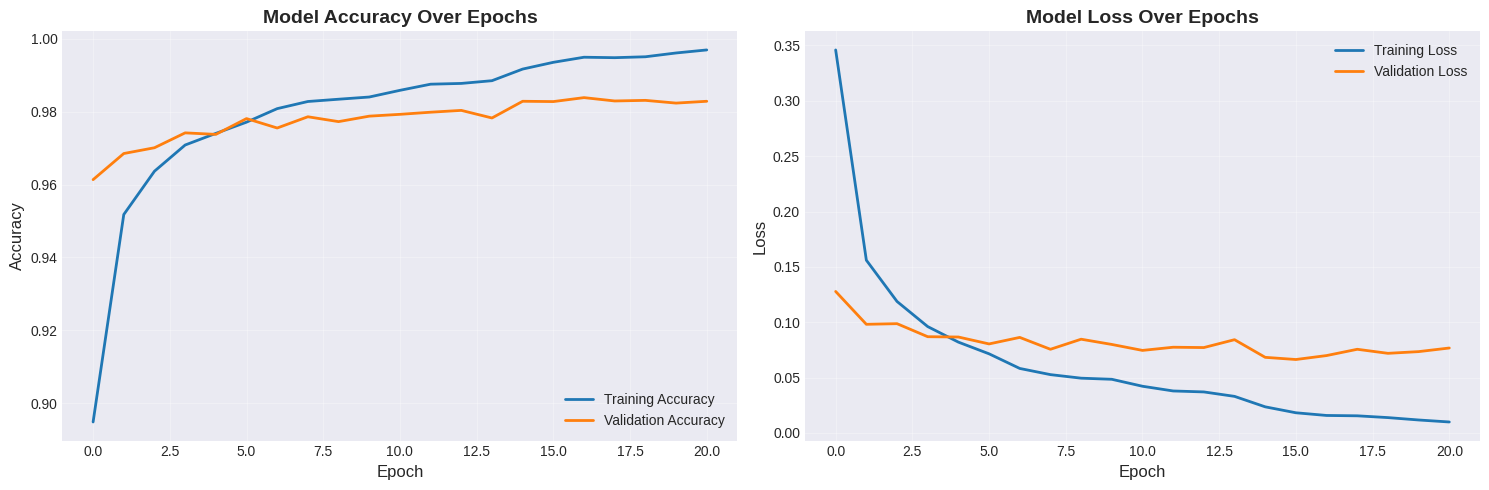

In [11]:
# Plot accuracy and loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Evaluate Model on Test Set

In [13]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test_flat, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred_probs = model.predict(x_test_flat, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)


Test Loss: 0.0668
Test Accuracy: 0.9832 (98.32%)


## 12. Generate Confusion Matrix

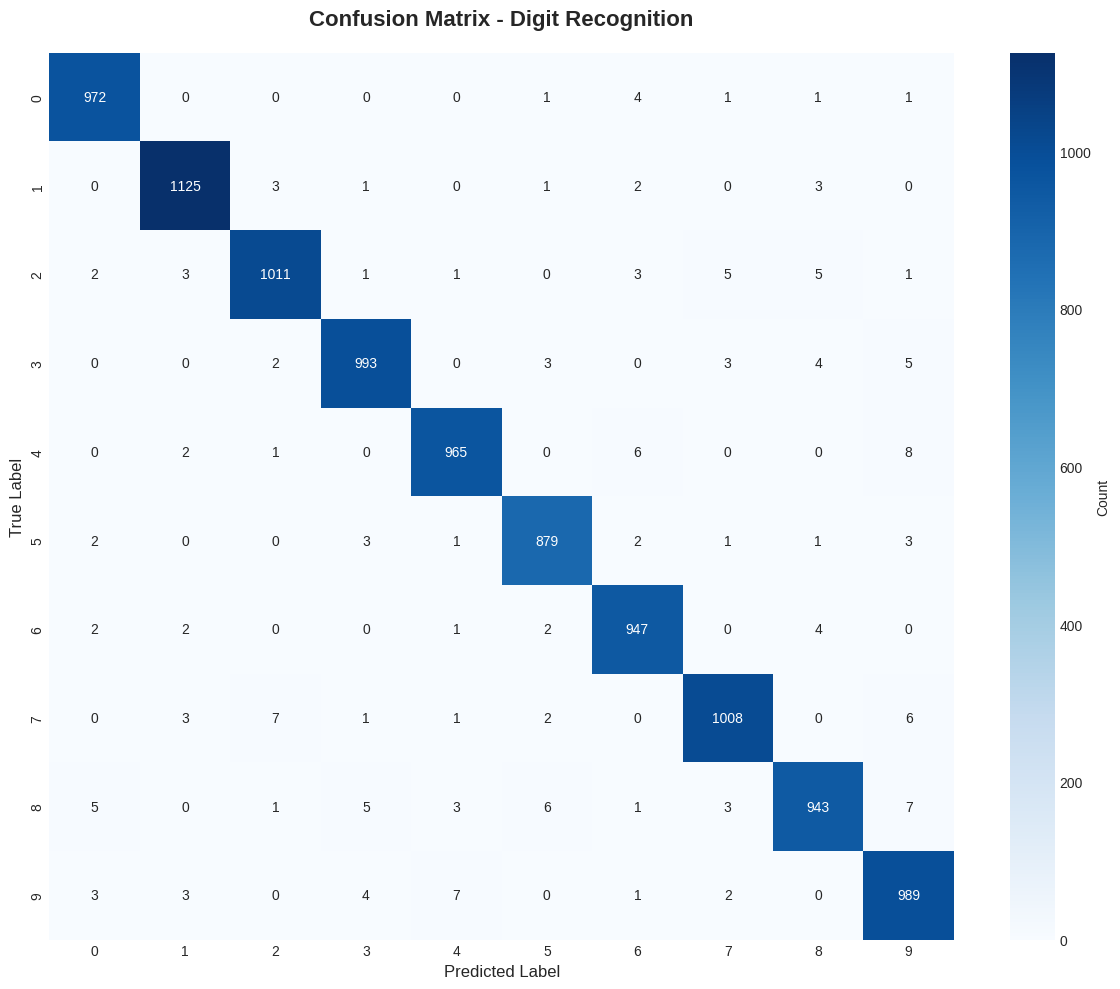


Per-class Accuracy:
Digit 0: 0.9918 (99.18%)
Digit 1: 0.9912 (99.12%)
Digit 2: 0.9797 (97.97%)
Digit 3: 0.9832 (98.32%)
Digit 4: 0.9827 (98.27%)
Digit 5: 0.9854 (98.54%)
Digit 6: 0.9885 (98.85%)
Digit 7: 0.9805 (98.05%)
Digit 8: 0.9682 (96.82%)
Digit 9: 0.9802 (98.02%)


In [14]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Digit Recognition', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('output/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for digit, acc in enumerate(class_accuracy):
    print(f"Digit {digit}: {acc:.4f} ({acc*100:.2f}%)")

## 13. Classification Report

In [15]:
# Print detailed classification report
print("\nDetailed Classification Report:")
print("="*60)
report = classification_report(y_test, y_pred,
                               target_names=[str(i) for i in range(10)],
                               digits=4)
print(report)

# Save report to file
with open('output/classification_report.txt', 'w') as f:
    f.write("Classification Report - Digit Recognition Model\n")
    f.write("="*60 + "\n\n")
    f.write(report)


Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9858    0.9918    0.9888       980
           1     0.9886    0.9912    0.9899      1135
           2     0.9863    0.9797    0.9830      1032
           3     0.9851    0.9832    0.9841      1010
           4     0.9857    0.9827    0.9842       982
           5     0.9832    0.9854    0.9843       892
           6     0.9803    0.9885    0.9844       958
           7     0.9853    0.9805    0.9829      1028
           8     0.9813    0.9682    0.9747       974
           9     0.9696    0.9802    0.9749      1009

    accuracy                         0.9832     10000
   macro avg     0.9831    0.9831    0.9831     10000
weighted avg     0.9832    0.9832    0.9832     10000



## 14. Per-Class Accuracy Visualization

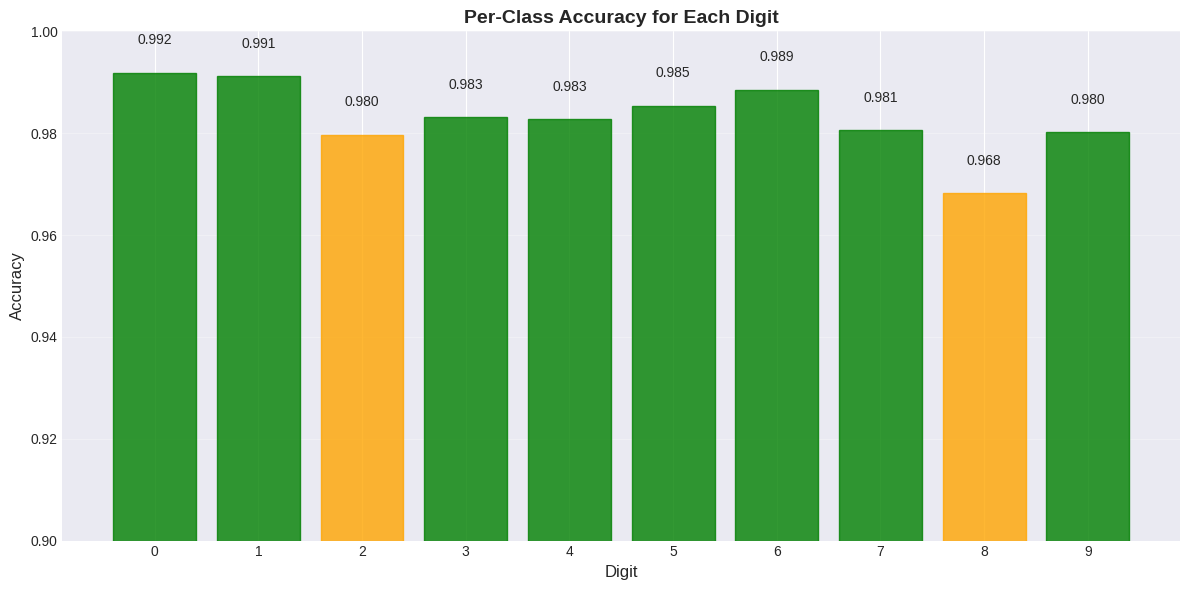

In [16]:
# Plot per-class accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(range(10), class_accuracy, color='steelblue', alpha=0.8, edgecolor='black')

# Color bars based on accuracy
for i, (bar, acc) in enumerate(zip(bars, class_accuracy)):
    if acc >= 0.98:
        bar.set_color('green')
    elif acc >= 0.95:
        bar.set_color('orange')
    else:
        bar.set_color('red')

    # Add value labels on bars
    plt.text(i, acc + 0.005, f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Digit', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy for Each Digit', fontsize=14, fontweight='bold')
plt.xticks(range(10))
plt.ylim([0.9, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('output/per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

## 15. Analyze Misclassified Examples


Total misclassified examples: 168 out of 10000
Error rate: 1.68%


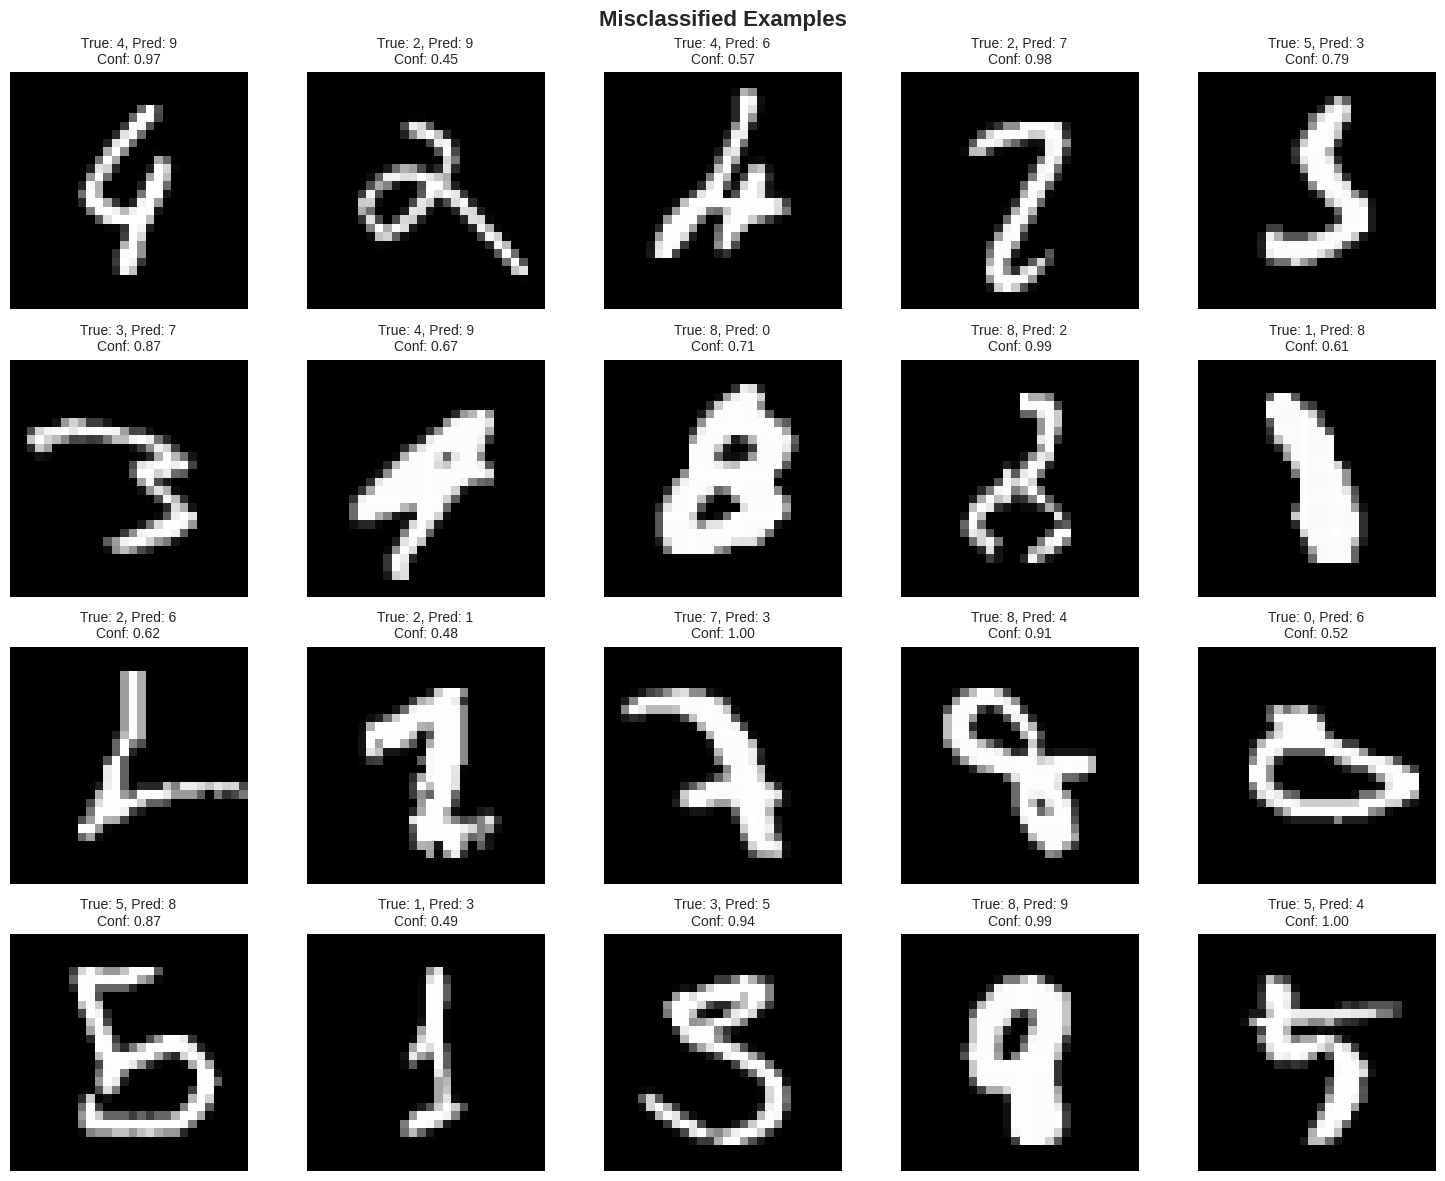

In [17]:
# Find misclassified examples
misclassified_idx = np.where(y_pred != y_test)[0]
print(f"\nTotal misclassified examples: {len(misclassified_idx)} out of {len(y_test)}")
print(f"Error rate: {len(misclassified_idx)/len(y_test)*100:.2f}%")

# Display some misclassified examples
if len(misclassified_idx) > 0:
    n_examples = min(20, len(misclassified_idx))
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Misclassified Examples', fontsize=16, fontweight='bold')

    for i, idx in enumerate(misclassified_idx[:n_examples]):
        row = i // 5
        col = i % 5
        axes[row, col].imshow(x_test[idx], cmap='gray')
        axes[row, col].set_title(f'True: {y_test[idx]}, Pred: {y_pred[idx]}\nConf: {y_pred_probs[idx][y_pred[idx]]:.2f}',
                                fontsize=10)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig('output/misclassified_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

## 16. Save Final Model and Metadata

In [20]:
import os

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

print("Saving model...")

# Native Keras format (recommended)
model.save(os.path.join(output_dir, "digit_recognition_model.keras"))
print("✓ Saved model as .keras format (recommended)")

# Legacy HDF5 (optional)
model.save(os.path.join(output_dir, "digit_recognition_model.h5"))
print("✓ Saved model as .h5 format (legacy)")

# Architecture only
with open(os.path.join(output_dir, "model_architecture.json"), "w") as f:
    f.write(model.to_json())
print("✓ Saved model architecture as JSON")

# Weights only (Keras 3 required naming)
model.save_weights(os.path.join(output_dir, "model.weights.h5"))
print("✓ Saved model weights")


Saving model...
✓ Saved model as .keras format (recommended)
✓ Saved model as .h5 format (legacy)
✓ Saved model architecture as JSON
✓ Saved model weights


## 17. Save Training Metadata

In [21]:
# Create metadata dictionary
metadata = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_architecture': {
        'input_shape': (28*28,),
        'layers': [
            {'type': 'Dense', 'units': 512, 'activation': 'relu'},
            {'type': 'BatchNormalization'},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'Dense', 'units': 256, 'activation': 'relu'},
            {'type': 'BatchNormalization'},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'Dense', 'units': 128, 'activation': 'relu'},
            {'type': 'BatchNormalization'},
            {'type': 'Dropout', 'rate': 0.2},
            {'type': 'Dense', 'units': 10, 'activation': 'softmax'}
        ],
        'total_parameters': model.count_params()
    },
    'training_config': {
        'optimizer': 'Adam',
        'initial_learning_rate': 0.001,
        'loss_function': 'sparse_categorical_crossentropy',
        'batch_size': 128,
        'epochs_trained': len(history.history['loss']),
        'validation_split': 0.2
    },
    'performance_metrics': {
        'test_accuracy': float(test_accuracy),
        'test_loss': float(test_loss),
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'best_val_accuracy': float(max(history.history['val_accuracy'])),
        'per_class_accuracy': {str(i): float(acc) for i, acc in enumerate(class_accuracy)},
        'total_misclassified': int(len(misclassified_idx)),
        'error_rate': float(len(misclassified_idx)/len(y_test))
    },
    'dataset_info': {
        'name': 'MNIST',
        'train_samples': len(x_train),
        'test_samples': len(x_test),
        'num_classes': 10,
        'image_shape': (28, 28)
    }
}

# Save metadata as JSON
with open('output/training_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("\n✓ Saved training metadata")
print("\nAll files saved in 'output/' directory:")
print("  - best_model.h5")
print("  - digit_recognition_model.h5")
print("  - digit_recognition_savedmodel/")
print("  - model_architecture.json")
print("  - model_weights.h5")
print("  - training_metadata.json")
print("  - sample_images.png")
print("  - training_history.png")
print("  - confusion_matrix.png")
print("  - per_class_accuracy.png")
print("  - misclassified_examples.png")
print("  - classification_report.txt")


✓ Saved training metadata

All files saved in 'output/' directory:
  - best_model.h5
  - digit_recognition_model.h5
  - digit_recognition_savedmodel/
  - model_architecture.json
  - model_weights.h5
  - training_metadata.json
  - sample_images.png
  - training_history.png
  - confusion_matrix.png
  - per_class_accuracy.png
  - misclassified_examples.png
  - classification_report.txt


## 18. Training Summary

In [22]:
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"\nModel Architecture:")
print(f"  - Total Parameters: {model.count_params():,}")
print(f"  - Hidden Layers: 3 (512, 256, 128 neurons)")
print(f"  - Regularization: Batch Normalization + Dropout")
print(f"\nTraining Configuration:")
print(f"  - Epochs Trained: {len(history.history['loss'])}")
print(f"  - Batch Size: 128")
print(f"  - Optimizer: Adam")
print(f"\nPerformance Metrics:")
print(f"  - Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"  - Total Misclassified: {len(misclassified_idx)} / {len(y_test)}")
print(f"  - Error Rate: {len(misclassified_idx)/len(y_test)*100:.2f}%")
print(f"\nModel saved successfully in 'output/' directory")
print("="*70)


TRAINING SUMMARY

Model Architecture:
  - Total Parameters: 571,018
  - Hidden Layers: 3 (512, 256, 128 neurons)
  - Regularization: Batch Normalization + Dropout

Training Configuration:
  - Epochs Trained: 21
  - Batch Size: 128
  - Optimizer: Adam

Performance Metrics:
  - Test Accuracy: 0.9832 (98.32%)
  - Test Loss: 0.0668
  - Best Validation Accuracy: 0.9838
  - Total Misclassified: 168 / 10000
  - Error Rate: 1.68%

Model saved successfully in 'output/' directory


## 19. Test Model Prediction (Optional)

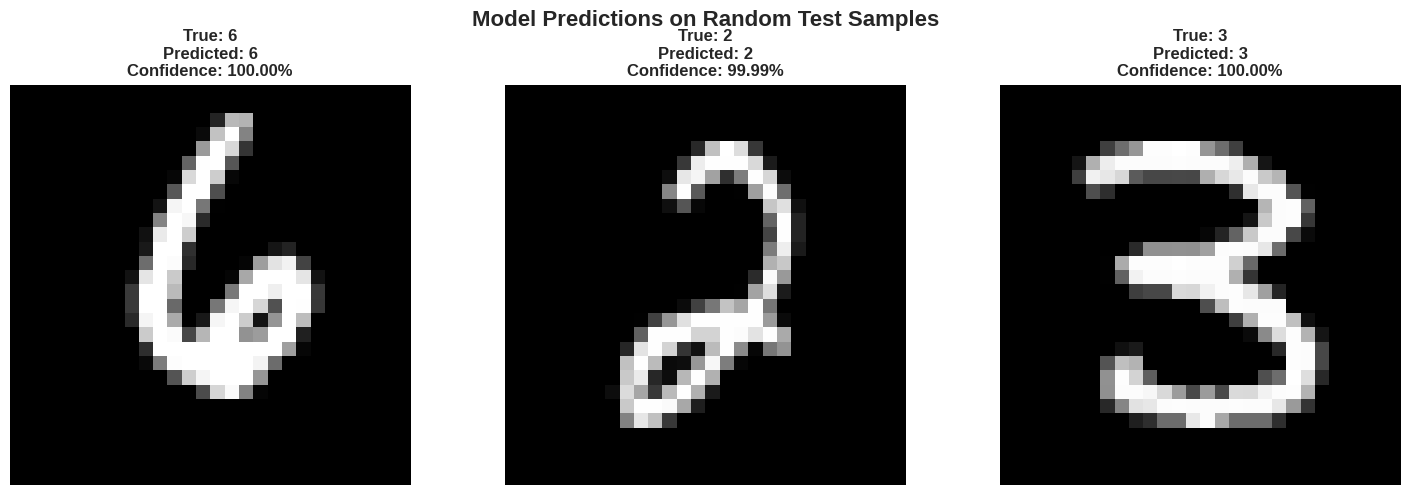

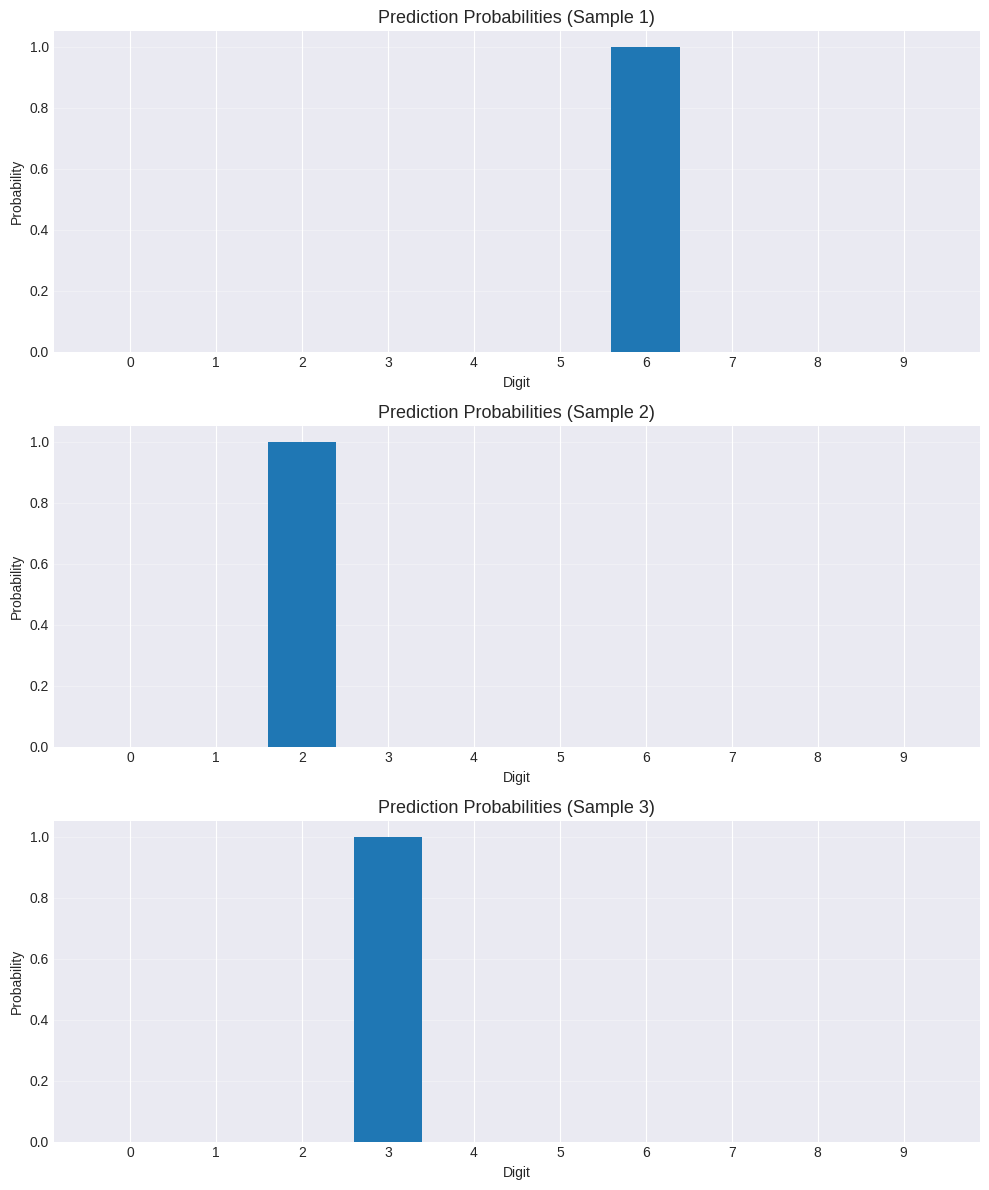

In [24]:
import numpy as np
import matplotlib.pyplot as plt

num_samples = 3

# Randomly select test indices
sample_indices = np.random.choice(len(x_test), num_samples, replace=False)

# Prepare data
sample_images = x_test[sample_indices]
sample_labels = y_test[sample_indices]
sample_inputs = x_test_flat[sample_indices]

# Make batch predictions
predictions = model.predict(sample_inputs, verbose=0)

# ---------- Display Images with Predictions ----------
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    pred_digit = np.argmax(predictions[i])
    confidence = predictions[i][pred_digit]

    axes[i].imshow(sample_images[i], cmap='gray')
    axes[i].set_title(
        f"True: {sample_labels[i]}\nPredicted: {pred_digit}\nConfidence: {confidence:.2%}",
        fontsize=12,
        fontweight='bold'
    )
    axes[i].axis('off')

plt.suptitle("Model Predictions on Random Test Samples", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ---------- Probability Distributions ----------
fig, axes = plt.subplots(num_samples, 1, figsize=(10, 4 * num_samples))

for i in range(num_samples):
    axes[i].bar(range(10), predictions[i])
    axes[i].set_title(f"Prediction Probabilities (Sample {i+1})", fontsize=13)
    axes[i].set_xlabel("Digit")
    axes[i].set_ylabel("Probability")
    axes[i].set_xticks(range(10))
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
import shutil

source_dir = "/content/output"
zip_path = "/content/output_results"

# Create ZIP file
shutil.make_archive(zip_path, 'zip', source_dir)

print("✓ Zipped all contents of /content/output into output_results.zip")


✓ Zipped all contents of /content/output into output_results.zip
